# Correlation Analyses Setup

## Importing Libraries and Data

In [38]:
# Importing Libraries
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from sklearn.decomposition import PCA
from sklearn.cluster import AgglomerativeClustering
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score
import matplotlib.cm as cm
%matplotlib inline
import seaborn as sns
sns.set(style = "whitegrid",
        color_codes = True,
        font_scale = 1.5)
import re
import pandas as pd

The next part assumes one has access to anonymized, confidential participant data from the BEES summer bridge program. If you do not have access, please import data in the format specified in the README and replace import statements to be compatible with your dataset. If you are just interested in the methodology, click the relevant sections below this.

In [39]:
# Survey Data
from google.colab import drive
drive.mount('/content/drive')
pre_2020 = pd.read_excel('/content/drive/My Drive/BEES Research Data/Data for Studies/2020 Pre Survey.xlsx')
pre_2021 = pd.read_excel('/content/drive/My Drive/BEES Research Data/Data for Studies/2021 Pre Survey.xlsx')
pre_2022 = pd.read_excel('/content/drive/My Drive/BEES Research Data/Data for Studies/2022 Pre Survey.xlsx')
pre_2022_new = pd.read_excel('/content/drive/My Drive/BEES Research Data/Data for Studies/2022-BEES-Pre-Survey-for-Shreya.xlsx')
pre_2022 = pd.concat([pre_2022, pre_2022_new.drop(index=(0), columns=["Q1", "Q20"])]).reset_index()
pre_2022=pre_2022.drop("index", axis=1)
pre_2023 = pd.read_excel('/content/drive/My Drive/BEES Research Data/Data for Studies/2023 Pre Survey.xlsx')
post_2020 = pd.read_excel('/content/drive/My Drive/BEES Research Data/Data for Studies/2020 Post Survey.xlsx')
post_2021 = pd.read_excel('/content/drive/My Drive/BEES Research Data/Data for Studies/2021 Post Survey.xlsx')
post_2022 = pd.read_excel('/content/drive/My Drive/BEES Research Data/Data for Studies/2022 Post Survey.xlsx')
post_2023 = pd.read_excel('/content/drive/My Drive/BEES Research Data/Data for Studies/2023 Post Survey.xlsx')

# Grade Data
performance_2020 = pd.read_excel('/content/drive/My Drive/BEES Research Data/Data for Studies/2020 Academic Performance.xlsx')
performance_2021 = pd.read_excel('/content/drive/My Drive/BEES Research Data/Data for Studies/2021 Academic Performance.xlsx')
performance_2022 = pd.read_excel('/content/drive/My Drive/BEES Research Data/Data for Studies/2022 Academic Performance.xlsx')
performance_2023 = pd.read_excel('/content/drive/My Drive/BEES Research Data/Data for Studies/2023 Academic Performance.xlsx')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Data Cleaning

Survey Data Pre-Processing

In [40]:
# Creating Lists of the dataframes to reduce code redundancy in the future
responses = [pre_2020, pre_2021, pre_2022, pre_2023, post_2020, post_2021, post_2022, post_2023]
unstandardized_column_names = [pre_2020, post_2020, post_2021, post_2022]
pres=[pre_2020, pre_2021, pre_2022, pre_2023]
posts=[post_2020, post_2021, post_2022, post_2023]

# Dropping Intended Majors and other Unnecessary Columns
for response in unstandardized_column_names:
  response.drop(labels= response.columns[[1]], axis=1, inplace=True)
post_2020.drop(labels= post_2020.columns[[1]], axis=1, inplace=True)

# Making column names uniform across all Dataframes
pre_2020.columns = pre_2021.columns
post_2020.columns = post_2021.columns

#Removing ScienceID_5 as the question is "If you are reading this item, please mark "3-Slightly Disagree""
for pre in pres:
  pre.drop(labels= "ScienceID_5", axis=1, inplace=True)
for post in posts:
  post.drop(labels= "ScienceID2_5", axis=1, inplace=True)

#Removing Columns with Qualitative Nominal Responses
pre_post_column_mismatches = ['Q24', 'Q26', 'Q28', 'Q30', 'Q34', 'Q38', 'Q42', 'Q44', 'Q46', 'Q48', 'Q50']
for post in posts:
  post.drop(labels= pre_post_column_mismatches, axis=1, inplace=True)

#Storing Questions for future reference
pre_survey_questions = pre_2022.iloc[0,:].str.replace(r'.*\n\n.* - |.* - ', '', regex=True)[1:]
pre_survey_questions.columns = ['Question_Text']

post_survey_questions = post_2022.iloc[0,:].str.replace(r'.*\n\n.* - |.* - ', '', regex=True)[1:]
post_survey_questions.columns = ['Question_Text']

#Making all the Columns Integers and Resetting Index to ResponseId
pre_2020 = pre_2020[1:].set_index('ResponseId').apply(pd.to_numeric)
post_2020 = post_2020[1:].set_index('ResponseId').apply(pd.to_numeric, errors='ignore')

pre_2021 = pre_2021[1:].set_index('ResponseId').replace(to_replace ='-.*', value = '', regex = True).apply(pd.to_numeric)
post_2021 = post_2021[2:].set_index('ResponseId').replace(to_replace ='-.*', value = '', regex = True).apply(pd.to_numeric, errors='ignore')

pre_2022 = pre_2022[1:].set_index('ResponseId').replace(to_replace ='-.*', value = '', regex = True).apply(pd.to_numeric)
post_2022 = post_2022[1:].set_index('ResponseId').replace(to_replace ='-.*', value = '', regex = True).apply(pd.to_numeric, errors='ignore')

pre_2023 = pre_2023[1:].set_index('ResponseId').replace(to_replace ='-.*', value = '', regex = True).apply(pd.to_numeric)
post_2023 = post_2023[1:].set_index('ResponseId').replace(to_replace ='-.*', value = '', regex = True).apply(pd.to_numeric, errors='ignore')

#Handling Negatively Worded Columns
pre_negative_6_options=["MathSelfConcept_2", "MathSelfConcept_4", "MathSelfConcept_6", "MathSelfConcept_8", "MathSelfConcept_10", "ProgramSelfConcept_2", "ProgramSelfConcept_4", "ProgramSelfConcept_6", "ProgramSelfConcept_8", "ProgramSelfConcept_10", "Mindset_1", "Mindset_2", "Mindset_3"]
pre_negative_4_options=["Concealment_1", "Concealment_2", "Concealment_3", "Concealment_4", "Concealment_5", "Concealment_6", "Concealment_7", "Concealment_8"]
post_negative_6_options=["MathSelfConcept2_2", "MathSelfConcept2_4", "MathSelfConcept2_6", "MathSelfConcept2_8", "MathSelfConcept2_10", "ProgramSelfConcept2_2", "ProgramSelfConcept2_4", "ProgramSelfConcept2_6", "ProgramSelfConcept2_8", "ProgramSelfConcept2_10", "Mindset2_1", "Mindset2_2", "Mindset2_3"]
post_negative_4_options=["Concealment2_1", "Concealment2_2", "Concealment2_3", "Concealment2_4", "Concealment2_5", "Concealment2_6", "Concealment2_7", "Concealment2_8"]

replacement_6_option= {1:6, 2:5, 3:4, 4:3, 5:2, 6:1}
replacement_4_option= {1:4, 2:3, 3:2, 4:1}

for column in pre_negative_6_options:
  pre_2020.replace({column:replacement_6_option}, inplace=True)
  pre_2021.replace({column:replacement_6_option}, inplace=True)
  pre_2022.replace({column:replacement_6_option}, inplace=True)
  pre_2023.replace({column:replacement_6_option}, inplace=True)
for column in pre_negative_4_options:
  pre_2020.replace({column:replacement_4_option}, inplace=True)
  pre_2021.replace({column:replacement_4_option}, inplace=True)
  pre_2022.replace({column:replacement_4_option}, inplace=True)
  pre_2023.replace({column:replacement_4_option}, inplace=True)
for column in post_negative_6_options:
  post_2020.replace({column:replacement_6_option}, inplace=True)
  post_2021.replace({column:replacement_6_option}, inplace=True)
  post_2022.replace({column:replacement_6_option}, inplace=True)
  post_2023.replace({column:replacement_6_option}, inplace=True)
for column in post_negative_4_options:
  post_2020.replace({column:replacement_4_option}, inplace=True)
  post_2021.replace({column:replacement_4_option}, inplace=True)
  post_2022.replace({column:replacement_4_option}, inplace=True)
  post_2023.replace({column:replacement_4_option}, inplace=True)
# Function to select a category of survey questions like Math, Programming, etc.
def select_category(df, cat) :
  return df[[col for col in df.columns if cat in col]]

# Category Labels Dictioanry
cat_labels = {'Math':'Math Self Concept', 'Program':'Program Self Concept', 'ScienceMotivation':'Science Motivation', 'ScienceID':'Science Self Indentity'
              , 'HelpSeeking':'Help Seeking' , 'Concealment':'Concealment', 'Mindset':'Mindset', 'PeerCommunity':'Peer Community'
              , 'CampusBelong':'Campus Belong', 'Resources':'Resources'}

#All newly formatted dfs
pres=[pre_2020, pre_2021, pre_2022, pre_2023]
posts=[post_2020, post_2021, post_2022, post_2023]

#Scaling function for all values in a column based on maxvalue (sometimes 4, sometimes 6)
def scale(df, col):
  max_val = np.max(df[col])
  df[col]= df.loc[:,col] / max_val
  return df

#Scaling each df
for pre_df in pres:
  for q_num in pre_df.columns:
    pre_df = scale(pre_df, q_num)
for post_df in posts:
  for q_num in post_df.columns:
    post_df = scale(post_df, q_num)

Academic Performance Data Pre-Processing

In [41]:
#Renaming Response ID column to ResponseId
performance_2020 = performance_2020.rename(columns={'Response ID': 'ResponseId'})
performance_2021 = performance_2021.rename(columns={'Response ID': 'ResponseId'})
performance_2022 = performance_2022.rename(columns={'Response ID': 'ResponseId'})
performance_2023 = performance_2023.rename(columns={'Response ID': 'ResponseId'})
#Setting index to ResponseId so that it can be merged with Pre and Post Data
performance_2020=performance_2020.set_index("ResponseId")
performance_2021=performance_2021.set_index("ResponseId")
performance_2022=performance_2022.set_index("ResponseId")
performance_2023=performance_2023.set_index("ResponseId")

gpa_labels_cleaned = {"A- ":"A-", "B+ ":"B+", "B- ":"B-", "C+ ":"C+"}
online_gpas_programming = pd.concat([performance_2020["CSE20 Grade"].replace(gpa_labels_cleaned), performance_2021["CSE20 Grade"].replace(gpa_labels_cleaned)], ignore_index=False, axis=0)
offline_gpas_programming = pd.concat([performance_2022["CSE20 Grade"].replace(gpa_labels_cleaned), performance_2023["CSE20 Grade"].replace(gpa_labels_cleaned)], ignore_index=False, axis=0)
online_gpas_math = pd.concat([performance_2020["Math 19A Grade"].replace(gpa_labels_cleaned), performance_2021["Math 19A Grade"].replace(gpa_labels_cleaned)], ignore_index=False, axis=0)
offline_gpas_math = pd.concat([performance_2022["Math 19A Grade"].replace(gpa_labels_cleaned), performance_2023["Math 19A Grade"].replace(gpa_labels_cleaned)], ignore_index=False, axis=0)

#GPA Dictionary
gpa_conversions = {"A+":4.0, "A":4.0, "A-":3.7, "A- ":3.7, "B+":3.3, "B+ ":3.3, "B":3.0, "B-":2.7, "B- ":2.7, "C+":2.3,"C+ ":2.3, "C":2.0, "C-":1.7, "D+":1.3, "D":1.0, "D-":0.7, "F":0, "P":1.7, "W":0}
#Converting letter grades to GPA for the first programming course (CS1)
cs_gpa_2020 = performance_2020["CSE20 Grade"].replace(gpa_conversions)
cs_gpa_2021 = performance_2021["CSE20 Grade"].replace(gpa_conversions)
cs_gpa_2022 = performance_2022["CSE20 Grade"].replace(gpa_conversions)
cs_gpa_2023 = performance_2023["CSE20 Grade"].replace(gpa_conversions)
#Converting letter grades to GPA for the first maths course (CS1)
math_gpa_2020 = performance_2020["Math 19A Grade"].replace(gpa_conversions)
math_gpa_2021 = performance_2021["Math 19A Grade"].replace(gpa_conversions)
math_gpa_2022 = performance_2022["Math 19A Grade"].replace(gpa_conversions)
math_gpa_2023 = performance_2023["Math 19A Grade"].replace(gpa_conversions)

Separating Online vs Offline - Pure Grade Data (50 for online, 56 for offline)

In [42]:
online_grades = pd.concat([post_2020, post_2021], ignore_index=False, axis=0)
online_grades = online_grades.join(how="inner", other=pd.concat([cs_gpa_2020, cs_gpa_2021], ignore_index=False, axis=0))
online_grades = online_grades.join(how="inner", other=pd.concat([math_gpa_2020, math_gpa_2021], ignore_index=False, axis=0))

offline_grades = pd.concat([post_2022, post_2023], ignore_index=False, axis=0)
offline_grades = offline_grades.join(how="inner", other=pd.concat([cs_gpa_2022, cs_gpa_2023], ignore_index=False, axis=0))
offline_grades = offline_grades.join(how="inner", other=pd.concat([math_gpa_2022, math_gpa_2023], ignore_index=False, axis=0))

In [43]:
#Online
major_2020 = performance_2020["status"].str.extract(r'declared ([\w\s&:]+) BA|declared ([\w\s&:]+) BS|^(exited[\w\s]+)|[pP]roposed ([\w\s&:]+)', expand=False)
major_2021 = performance_2021["status"].str.extract(r'declared ([\w\s&:]+) BA|declared ([\w\s&:]+) BS|^(exited[\w\s]+)|[pP]roposed ([\w\s&:]+)', expand=False)
standing_2020 = performance_2020["status"].str.extract(r'([\w\s&:]+) standing', expand=False)
standing_2021 = performance_2021["status"].str.extract(r'([\w\s&:]+) standing', expand=False)
major_online = pd.concat([major_2020, major_2021], ignore_index=False, axis=0)
standing_online = pd.concat([standing_2020, standing_2021], ignore_index=False, axis=0)
performance_online = online_grades.join(how="inner", other=pd.concat([major_online, standing_online], ignore_index=False, axis=1))
performance_online = performance_online.rename(columns={0: "Declared BA", 1: "Declared BS", 2: "Exited", 3:"Proposed Major", "status":"Standing"})

# Offline
major_2022 = performance_2022["status"].str.extract(r'declared ([\w\s&:]+) BA|declared ([\w\s&:]+) BS|^(exited[\w\s]+)|[pP]roposed ([\w\s&:]+)', expand=False)
# major_2023 DNE because very recent.
standing_2022 = performance_2022["status"].str.extract(r'([\w\s&:]+) standing', expand=False)
standing_2023 = performance_2023["status"].str.extract(r'([\w\s&:]+) standing', expand=False)
standing_offline = pd.concat([standing_2022, standing_2023], ignore_index=False, axis=0)
performance_offline = offline_grades.join(how="left", other=pd.concat([pd.concat([major_2022, standing_2022], ignore_index=False, axis=1), pd.DataFrame(standing_2023)], ignore_index=False, axis=0))
performance_offline = performance_offline.rename(columns={0: "Declared BA", 1: "Declared BS", 2: "Exited", 3:"Proposed Major", "status":"Standing"})

## Exploratory Data Analysis (Included in Thesis)

In [44]:
print("Proportion of Students with 3.0+ GPA in Intro Programming")
print("Online: ", (online_grades["CSE20 Grade"]>=3.0).sum()/online_grades.shape[0], "\nOffline:", (offline_grades["CSE20 Grade"]>=3.0).sum() / offline_grades.shape[0])

Proportion of Students with 3.0+ GPA in Intro Programming
Online:  0.6 
Offline: 0.7142857142857143


In [45]:
print("Proportion of Students with 3.0+ GPA in Intro Maths")
print("Online: ", (online_grades["Math 19A Grade"]>=3.0).sum()/online_grades.shape[0], "\nOffline:", (offline_grades["Math 19A Grade"]>=3.0).sum() / offline_grades.shape[0])

Proportion of Students with 3.0+ GPA in Intro Maths
Online:  0.66 
Offline: 0.6964285714285714


In [46]:
print("Proportion of Online Students Declared BS & BA -measuring college retention, not just STEM retention")
print("Online: ", (performance_online["Declared BS"].count()+performance_online["Declared BA"].count())/performance_online["Declared BS"].size)

Proportion of Online Students Declared BS & BA -measuring college retention, not just STEM retention
Online:  0.82


In [47]:
print("Proportion of Offline Students Declared BS OR good standing in proposed major")
num_bsba = performance_offline["Declared BS"].count()+performance_offline["Declared BA"].count()
good_standing =  performance_offline["Standing"].str.contains("good").sum() #len(performance_offline[performance_offline["Standing"].str.contains("good")]) # not necessary bc once declared it's ok. & ~pd.isnull(performance_offline["Proposed Major"])])
print("Offline: ", (num_bsba + good_standing)/len(performance_offline))

Proportion of Offline Students Declared BS OR good standing in proposed major
Offline:  0.6964285714285714


## Correlation 1 - Good Standing and Math/Programming Grades Online vs Offline

### Mathematics

Correlation between students declaring in 2020 & 2021 and Math Grade:  0.05918821939626583
Correlation between students with good standing in 2022 & 2023 and Math Grade:  0.7373006539872351


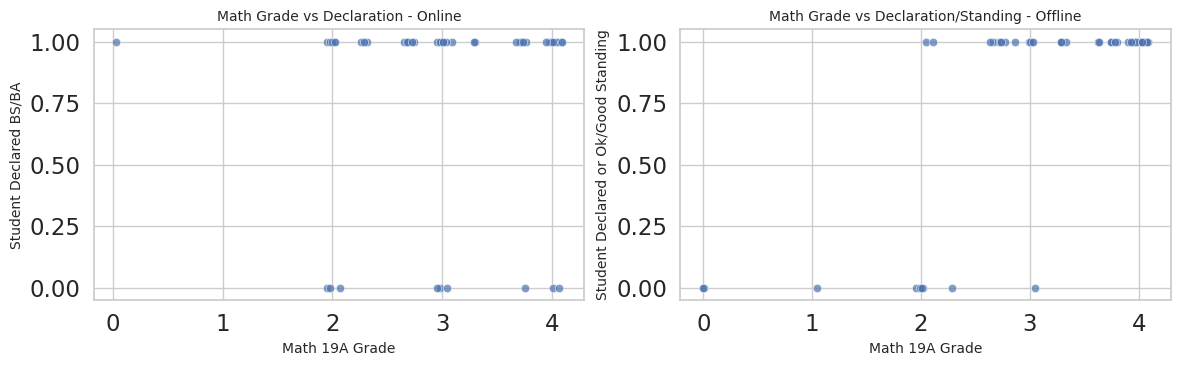

In [48]:
# No correlation between "If Students Declared" vs "Math Grade"
print("Correlation between students declaring in 2020 & 2021 and Math Grade: ", (~pd.isnull(performance_online["Declared BA"]) | ~pd.isnull(performance_online["Declared BS"])).corr(performance_online["Math 19A Grade"]))
noise = np.random.normal(0,0.05,performance_online["Math 19A Grade"].shape[0])

# Heavily weighted on the top right section for combined BS&BA.
plt.figure(figsize=(12,4))

SMALL_SIZE = 8
MEDIUM_SIZE = 10
plt.rc('axes', titlesize=MEDIUM_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels


plt.subplot(1, 2, 1)
sns.scatterplot(x=performance_online["Math 19A Grade"]+noise, y=(~pd.isnull(performance_online["Declared BA"]) + ~pd.isnull(performance_online["Declared BS"])),
                alpha=0.7)
plt.ylabel("Student Declared BS/BA")
plt.title("Math Grade vs Declaration - Online")

# Strong Positive Correlation between "If Students Declared/ in ok to good standing vs "Math Grade"
condition_good = (~pd.isnull(performance_offline["Declared BS"]) + (
                                                        (performance_offline["Standing"].str.contains("good")) | (performance_offline["Standing"].str.contains("ok"))))
print("Correlation between students with good standing in 2022 & 2023 and Math Grade: ", condition_good.corr(performance_offline["Math 19A Grade"]))
noise = np.random.normal(0,0.05,performance_offline["Math 19A Grade"].shape[0])

#Amongst those who declared/ok-good standing, math grades are higher.
plt.subplot(1, 2, 2)
sns.scatterplot(x=performance_offline["Math 19A Grade"]+noise, y=condition_good, alpha=0.7)
plt.ylabel("Student Declared or Ok/Good Standing")
plt.title("Math Grade vs Declaration/Standing - Offline")

plt.tight_layout()
plt.show();

### Programming

Correlation between students declaring in 2020 & 2021 and Programming Grade:  0.04827546883008215
Correlation between students with good standing in 2022 & 2023 and Programming Grade:  0.5789217569158203


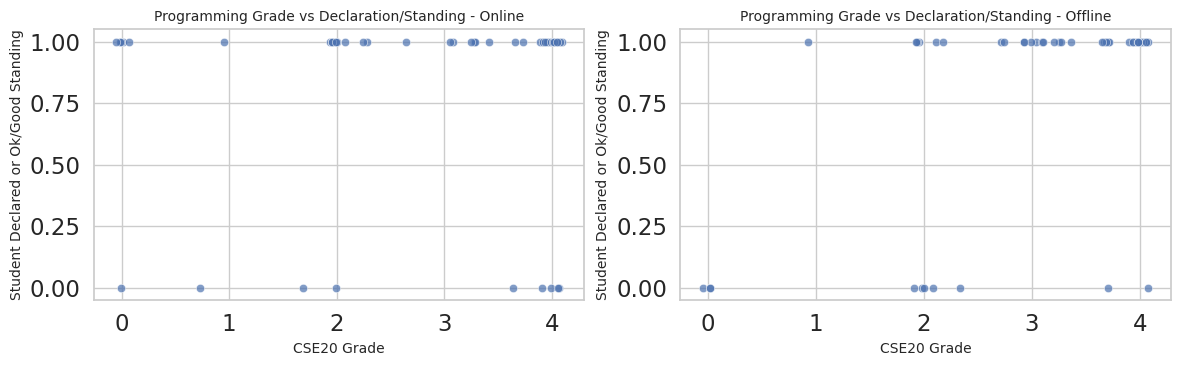

In [49]:
# No correlation between "If Students Declared" vs "Programming Grade"
print("Correlation between students declaring in 2020 & 2021 and Programming Grade: ", (~pd.isnull(performance_online["Declared BA"]) + ~pd.isnull(performance_online["Declared BS"])).corr(performance_online["CSE20 Grade"]))
noise = np.random.normal(0,0.05,performance_online["CSE20 Grade"].shape[0])

# Hard to make conclusions
plt.figure(figsize=(12,4))
plt.subplot(1, 2, 1)
sns.scatterplot(x=performance_online["CSE20 Grade"]+noise, y=(~pd.isnull(performance_online["Declared BA"]) + ~pd.isnull(performance_online["Declared BS"])),
                alpha=0.7)
plt.ylabel("Student Declared or Ok/Good Standing")
plt.title("Programming Grade vs Declaration/Standing - Online")

condition_good = (~pd.isnull(performance_offline["Declared BS"]) + (
                                                        (performance_offline["Standing"].str.contains("good")) | (performance_offline["Standing"].str.contains("ok"))))

#Positive Correlation between "If Students Declared/ in ok to good standing vs "Programming Grade"
print("Correlation between students with good standing in 2022 & 2023 and Programming Grade: ", condition_good.corr(performance_offline["CSE20 Grade"]))
noise = np.random.normal(0,0.05,performance_offline["CSE20 Grade"].shape[0])

plt.subplot(1, 2, 2)
sns.scatterplot(x=performance_offline["CSE20 Grade"]+noise, y=condition_good, alpha=0.7)
plt.ylabel("Student Declared or Ok/Good Standing")
plt.title("Programming Grade vs Declaration/Standing - Offline")

plt.tight_layout()
plt.show();

## Correlation 2(a) - Non-Academic Indicators and Math/Programming Grades ONLINE

### Setup

In [50]:
def row_average(row):
    non_null_values = row.dropna()
    if non_null_values.empty:
        return 0
    else:
        return non_null_values.mean()

# FOR POST DFS
survey_data_online = performance_online.copy().drop(["Standing", "Proposed Major", "Exited", "Declared BS", "Declared BA"], axis=1)
survey_data_offline = performance_offline.copy().drop(["Standing", "Proposed Major", "Exited", "Declared BS", "Declared BA"], axis=1)
# Apply the function row-wise to calculate row-wise averages
row_averages_online = survey_data_online.apply(row_average, axis=1)
row_averages_offline = survey_data_offline.apply(row_average, axis=1)
cleaned_survey_data_online = survey_data_online.apply(lambda row: row.fillna(row_averages_online[row.name]), axis=1)
cleaned_survey_data_offline = survey_data_offline.apply(lambda row: row.fillna(row_averages_offline[row.name]), axis=1)

#matching column names!
cleaned_survey_data_online.columns = list(pre_2020.columns)+["CSE20 Grade","Math 19A Grade"]
cleaned_survey_data_offline.columns = list(pre_2020.columns)+["CSE20 Grade","Math 19A Grade"]

#Function to get column names based on column indices
def column_names(df, array_indices):
  return df.columns[array_indices]

important_feature_set_online = set()
important_feature_set_offline = set()

# FOR DELTA DFS

#2020
common_ids_2020 = pre_2020.filter(items = post_2020.index.to_list(), axis=0).index.to_list()
delta_df_2020 = post_2020.copy().filter(items = common_ids_2020, axis=0)
delta_df_2020.columns = pre_2020.columns
delta_df_2020 = delta_df_2020 - pre_2020.copy().filter(items = common_ids_2020, axis=0)

#2021
common_ids_2021 = pre_2021.filter(items = post_2021.index.to_list(), axis=0).index.to_list()
delta_df_2021 = post_2021.copy().filter(items = common_ids_2021, axis=0)
delta_df_2021.columns = pre_2021.columns
delta_df_2021 = delta_df_2021 - pre_2021.copy().filter(items = common_ids_2021, axis=0)

#2022
common_ids_2022 = pre_2022.filter(items = post_2022.index.to_list(), axis=0).index.to_list()
delta_df_2022 = post_2022.copy().filter(items = common_ids_2022, axis=0)
delta_df_2022.columns = pre_2022.columns
delta_df_2022 = delta_df_2022 - pre_2022.copy().filter(items = common_ids_2022, axis=0)

#2023
common_ids_2023 = pre_2023.filter(items = post_2023.index.to_list(), axis=0).index.to_list()
delta_df_2023 = post_2023.copy().filter(items = common_ids_2023, axis=0)
delta_df_2023.columns = pre_2023.columns
delta_df_2023 = delta_df_2023 - pre_2023.copy().filter(items = common_ids_2023, axis=0)

#Online delta
online_delta = pd.concat([delta_df_2020, delta_df_2021], ignore_index=False, axis=0)
online_delta = online_delta.join(how="inner", other=pd.concat([cs_gpa_2020, cs_gpa_2021], ignore_index=False, axis=0))
online_delta = online_delta.join(how="inner", other=pd.concat([math_gpa_2020, math_gpa_2021], ignore_index=False, axis=0))

#Offline delta
offline_delta = pd.concat([delta_df_2022, delta_df_2023], ignore_index=False, axis=0)
offline_delta = offline_delta.join(how="inner", other=pd.concat([cs_gpa_2022, cs_gpa_2023], ignore_index=False, axis=0))
offline_delta = offline_delta.join(how="inner", other=pd.concat([math_gpa_2022, math_gpa_2023], ignore_index=False, axis=0))

#cleaned delta dfs
cleaned_online_delta = online_delta.copy().dropna().apply(pd.to_numeric)
cleaned_offline_delta = offline_delta.copy().dropna().apply(pd.to_numeric)

### POST SURVEY RESPONSES + MATH GRADE DATA

Mean Squared Error: 0.8350307593132957


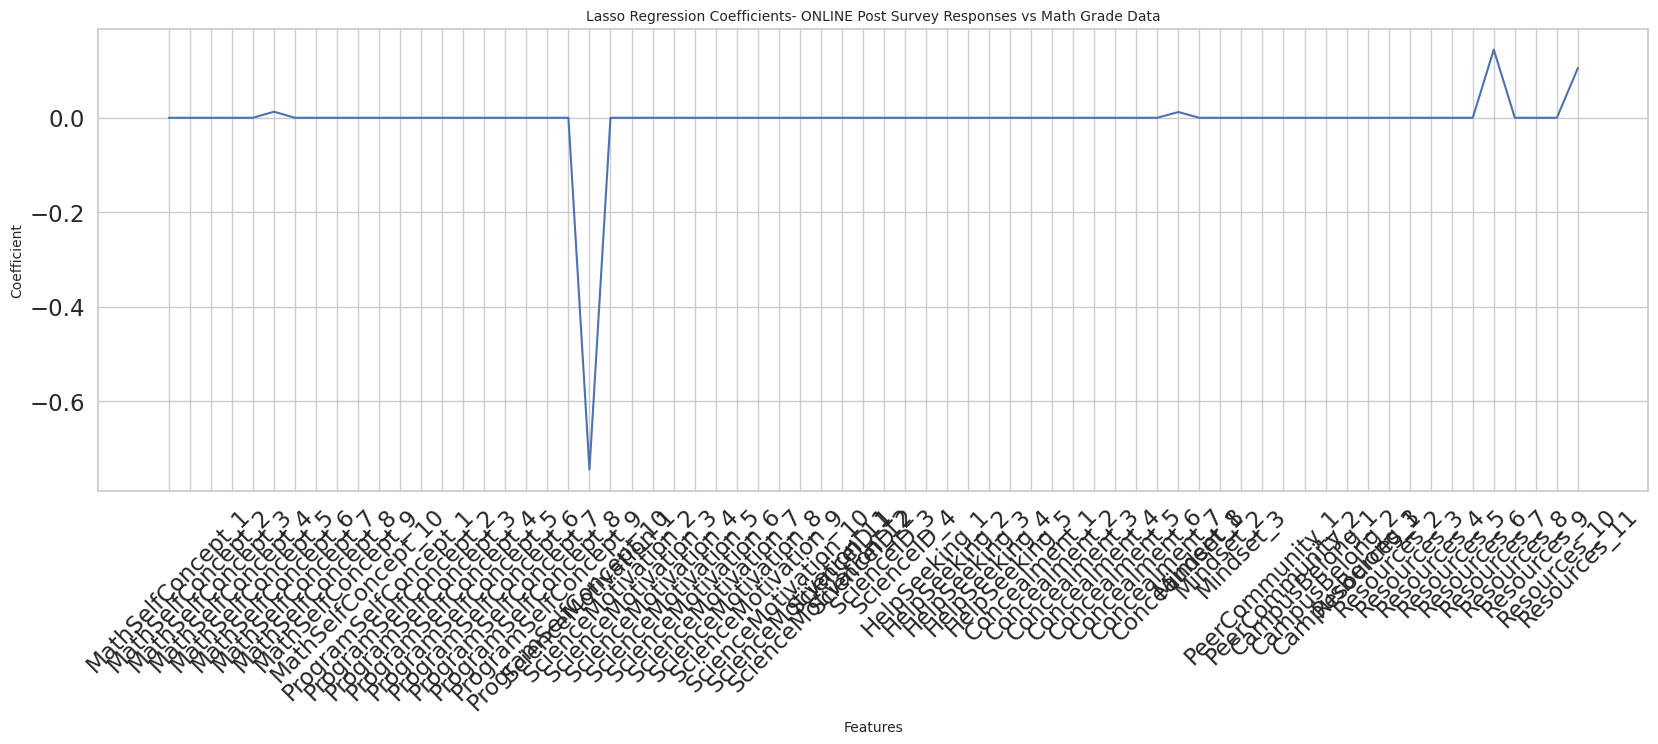

In [51]:
X_train, X_test, y_train, y_test = train_test_split(cleaned_survey_data_online.copy().drop(["CSE20 Grade", "Math 19A Grade"], axis=1),
                                                    cleaned_survey_data_online["Math 19A Grade"], test_size=0.2, random_state=42)
lasso = Lasso(alpha=0.0325) #arbitarily picked
lasso.fit(X_train, y_train)
y_pred = lasso.predict(X_test)
# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
print("Mean Squared Error:", mse)

# Plot feature coefficients
plt.figure(figsize=(20, 6))
plt.plot(range(len(lasso.coef_)), lasso.coef_)
plt.xticks(range(len(cleaned_survey_data_online.copy().drop(["CSE20 Grade", "Math 19A Grade"], axis=1).columns)), cleaned_survey_data_online.copy().drop(["CSE20 Grade", "Math 19A Grade"], axis=1).columns, rotation=45)
plt.title("Lasso Regression Coefficients- ONLINE Post Survey Responses vs Math Grade Data")
plt.xlabel("Features")
plt.ylabel("Coefficient")
plt.grid(True)
plt.show()

lasso_features_significant=list(column_names(cleaned_survey_data_online.copy().drop(["CSE20 Grade", "Math 19A Grade"], axis=1),np.where(np.abs(lasso.coef_)>0.0)[0]))
important_feature_set_online.update(lasso_features_significant)
feature_and_correlations={}
for feature in lasso_features_significant:
  corr = cleaned_survey_data_online[feature].corr(cleaned_survey_data_online["Math 19A Grade"])
  feature_and_correlations[feature]=corr

math_post_features_online = lasso_features_significant

In [52]:
feature_and_correlations

{'MathSelfConcept_6': 0.11042630115306988,
 'ScienceMotivation_1': -0.19437776352659883,
 'Concealment_8': -0.0013482850899555372,
 'Resources_7': 0.056801379981279446,
 'Resources_11': 0.17162489902436934}

### POST SURVEY RESPONSES + PROGRAMMING GRADE DATA

---



Mean Squared Error: 1.387248443862567


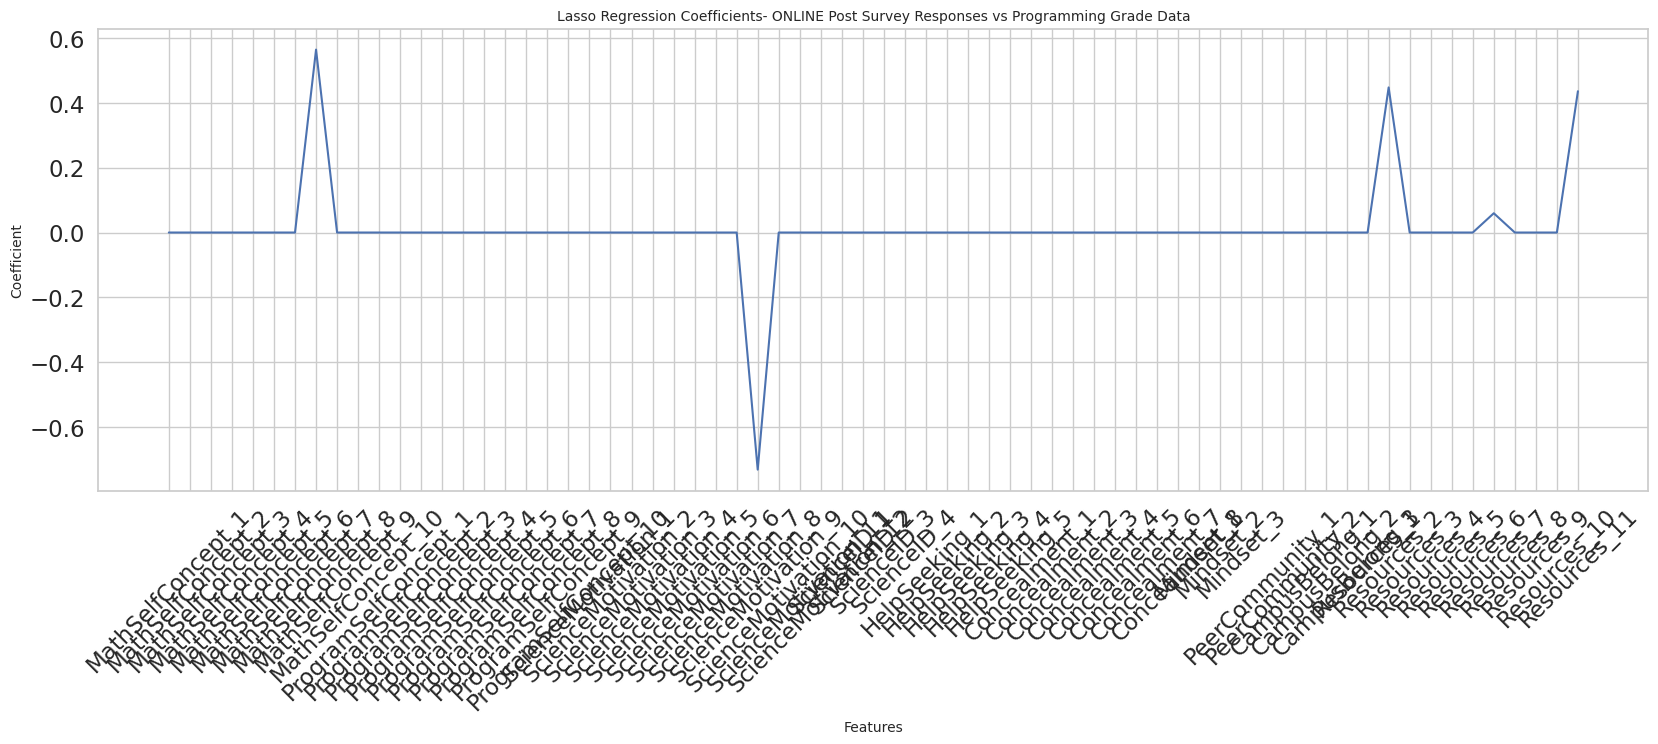

In [53]:
X_train, X_test, y_train, y_test = train_test_split(cleaned_survey_data_online.copy().drop(["CSE20 Grade", "Math 19A Grade"], axis=1),
                                                    cleaned_survey_data_online["CSE20 Grade"], test_size=0.2, random_state=42)
lasso = Lasso(alpha=0.065) #arbitarily picked
lasso.fit(X_train, y_train)
y_pred = lasso.predict(X_test)
# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
print("Mean Squared Error:", mse)

# Plot feature coefficients
plt.figure(figsize=(20, 6))
plt.plot(range(len(lasso.coef_)), lasso.coef_)
plt.xticks(range(len(cleaned_survey_data_online.copy().drop(["CSE20 Grade", "Math 19A Grade"], axis=1).columns)), cleaned_survey_data_online.copy().drop(["CSE20 Grade", "Math 19A Grade"], axis=1).columns, rotation=45)
plt.title("Lasso Regression Coefficients- ONLINE Post Survey Responses vs Programming Grade Data")
plt.xlabel("Features")
plt.ylabel("Coefficient")
plt.grid(True)
plt.show()

lasso_features_significant=list(column_names(cleaned_survey_data_online.copy().drop(["CSE20 Grade", "Math 19A Grade"], axis=1),np.where(np.abs(lasso.coef_)>0.0)[0]))
important_feature_set_online.update(lasso_features_significant)
feature_and_correlations={}
for feature in lasso_features_significant:
  corr = cleaned_survey_data_online[feature].corr(cleaned_survey_data_online["Math 19A Grade"])
  feature_and_correlations[feature]=corr

programming_post_features_online = lasso_features_significant

In [54]:
feature_and_correlations

{'MathSelfConcept_8': 0.0803253784761343,
 'ScienceMotivation_9': -0.11034680461350871,
 'Resources_2': 0.14280963023510423,
 'Resources_7': 0.056801379981279446,
 'Resources_11': 0.17162489902436934}

### DELTA SURVEY RESPONSES + MATH GRADE DATA

Mean Squared Error: 0.7851511272274735


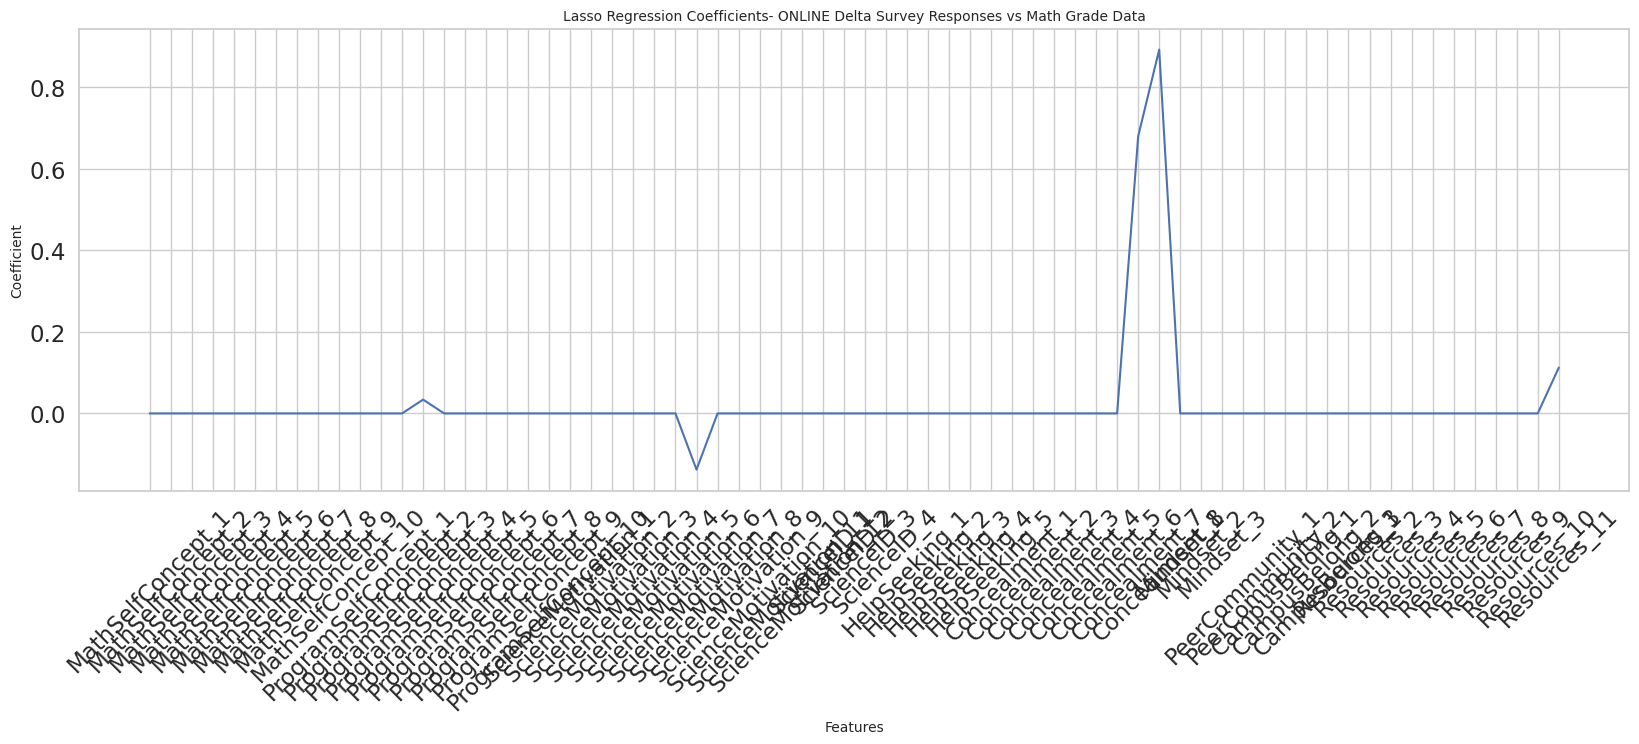

In [55]:
X_train, X_test, y_train, y_test = train_test_split(cleaned_online_delta.copy().drop(["CSE20 Grade", "Math 19A Grade"], axis=1),
                                                    cleaned_online_delta["Math 19A Grade"], test_size=0.2, random_state=42)
lasso = Lasso(alpha=0.045) #arbitarily picked
lasso.fit(X_train, y_train)
y_pred = lasso.predict(X_test)
# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
print("Mean Squared Error:", mse)

# Plot feature coefficients
plt.figure(figsize=(20, 6))
plt.plot(range(len(lasso.coef_)), lasso.coef_)
plt.xticks(range(len(cleaned_online_delta.copy().drop(["CSE20 Grade", "Math 19A Grade"], axis=1).columns)), cleaned_online_delta.copy().drop(["CSE20 Grade", "Math 19A Grade"], axis=1).columns, rotation=45)
plt.title("Lasso Regression Coefficients- ONLINE Delta Survey Responses vs Math Grade Data")
plt.xlabel("Features")
plt.ylabel("Coefficient")
plt.grid(True)
plt.show()

lasso_features_significant=list(column_names(cleaned_online_delta.copy().drop(["CSE20 Grade", "Math 19A Grade"], axis=1),np.where(np.abs(lasso.coef_)>0.0)[0]))
important_feature_set_online.update(lasso_features_significant)
feature_and_correlations={}
for feature in lasso_features_significant:
  corr = cleaned_online_delta[feature].corr(cleaned_online_delta["Math 19A Grade"])
  feature_and_correlations[feature]=corr

math_delta_features_online = lasso_features_significant

In [56]:
feature_and_correlations

{'ProgramSelfConcept_4': 0.34747612294086055,
 'ScienceMotivation_7': -0.4071171821438887,
 'Concealment_7': 0.2987683684997471,
 'Concealment_8': 0.2943381702818534,
 'Resources_11': 0.17899254977532333}

### DELTA SURVEY RESPONSES + PROGRAMMING GRADE DATA

Mean Squared Error: 1.9335662359737307


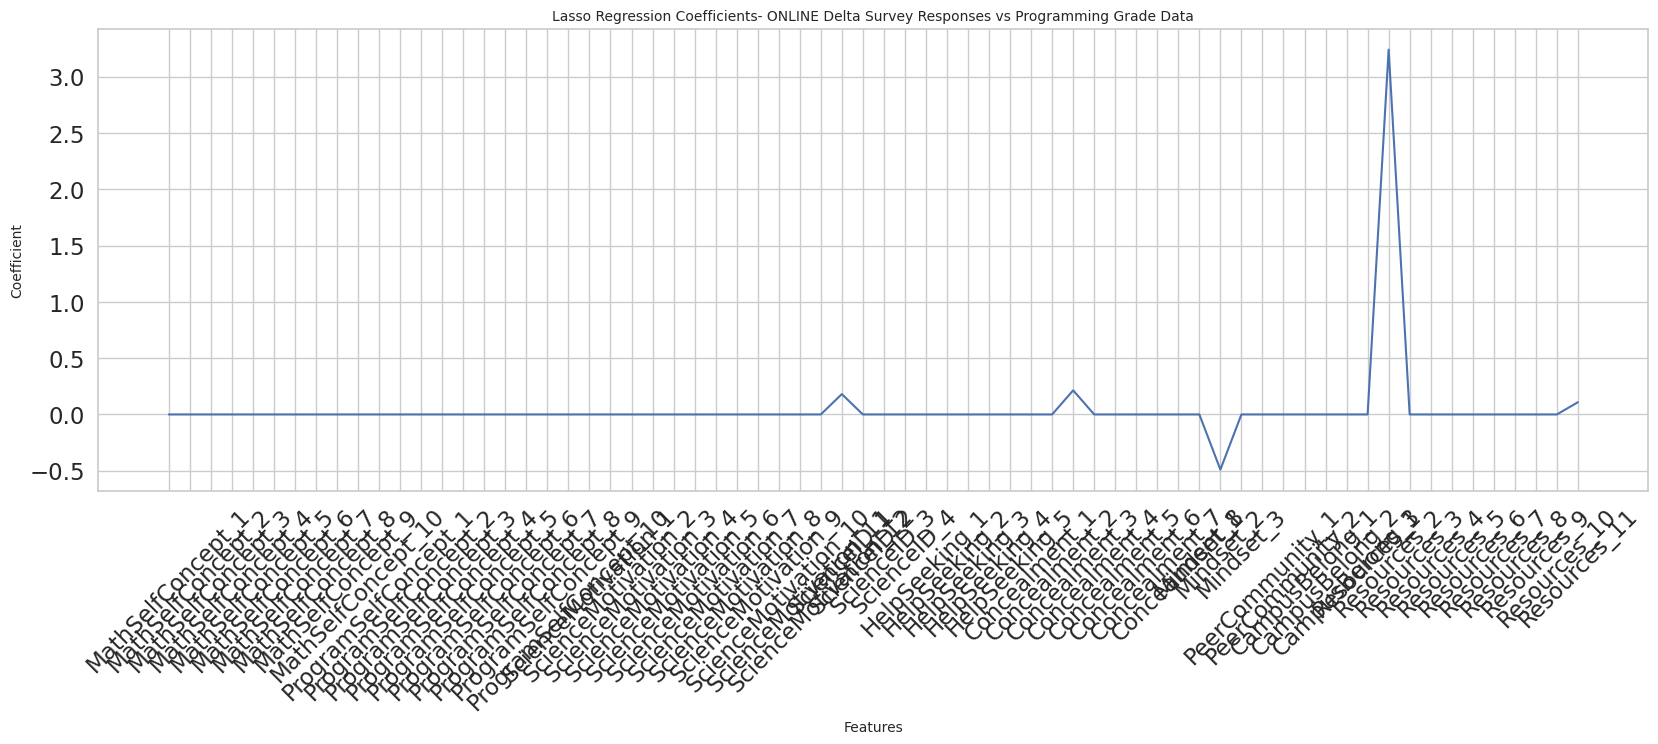

In [57]:
X_train, X_test, y_train, y_test = train_test_split(cleaned_online_delta.copy().drop(["CSE20 Grade", "Math 19A Grade"], axis=1),
                                                    cleaned_online_delta["CSE20 Grade"], test_size=0.2, random_state=42)
lasso = Lasso(alpha=0.06) #arbitarily picked
lasso.fit(X_train, y_train)
y_pred = lasso.predict(X_test)
# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
print("Mean Squared Error:", mse)

# Plot feature coefficients
plt.figure(figsize=(20, 6))
plt.plot(range(len(lasso.coef_)), lasso.coef_)
plt.xticks(range(len(cleaned_online_delta.copy().drop(["CSE20 Grade", "Math 19A Grade"], axis=1).columns)), cleaned_online_delta.copy().drop(["CSE20 Grade", "Math 19A Grade"], axis=1).columns, rotation=45)
plt.title("Lasso Regression Coefficients- ONLINE Delta Survey Responses vs Programming Grade Data")
plt.xlabel("Features")
plt.ylabel("Coefficient")
plt.grid(True)
plt.show()

lasso_features_significant=list(column_names(cleaned_online_delta.copy().drop(["CSE20 Grade", "Math 19A Grade"], axis=1),np.where(np.abs(lasso.coef_)>0.0)[0]))
important_feature_set_online.update(lasso_features_significant)
feature_and_correlations={}
for feature in lasso_features_significant:
  corr = cleaned_online_delta[feature].corr(cleaned_online_delta["CSE20 Grade"])
  feature_and_correlations[feature]=corr

programming_delta_features_online = lasso_features_significant

In [58]:
print("Significant Delta Online Features and their Correlations: \n")
feature_and_correlations

Significant Delta Online Features and their Correlations: 



{'ScienceID_1': 0.18380286016233055,
 'Concealment_3': 0.20713502724384858,
 'Mindset_2': -0.25199133558505693,
 'Resources_2': 0.6278572493232505,
 'Resources_11': 0.31305338886350986}

## Correlation 2(b) - Non-Academic Indicators and Math/Programming Grades OFFLINE

### POST SURVEY RESPONSES + MATH GRADE DATA

Mean Squared Error: 0.813418907017744


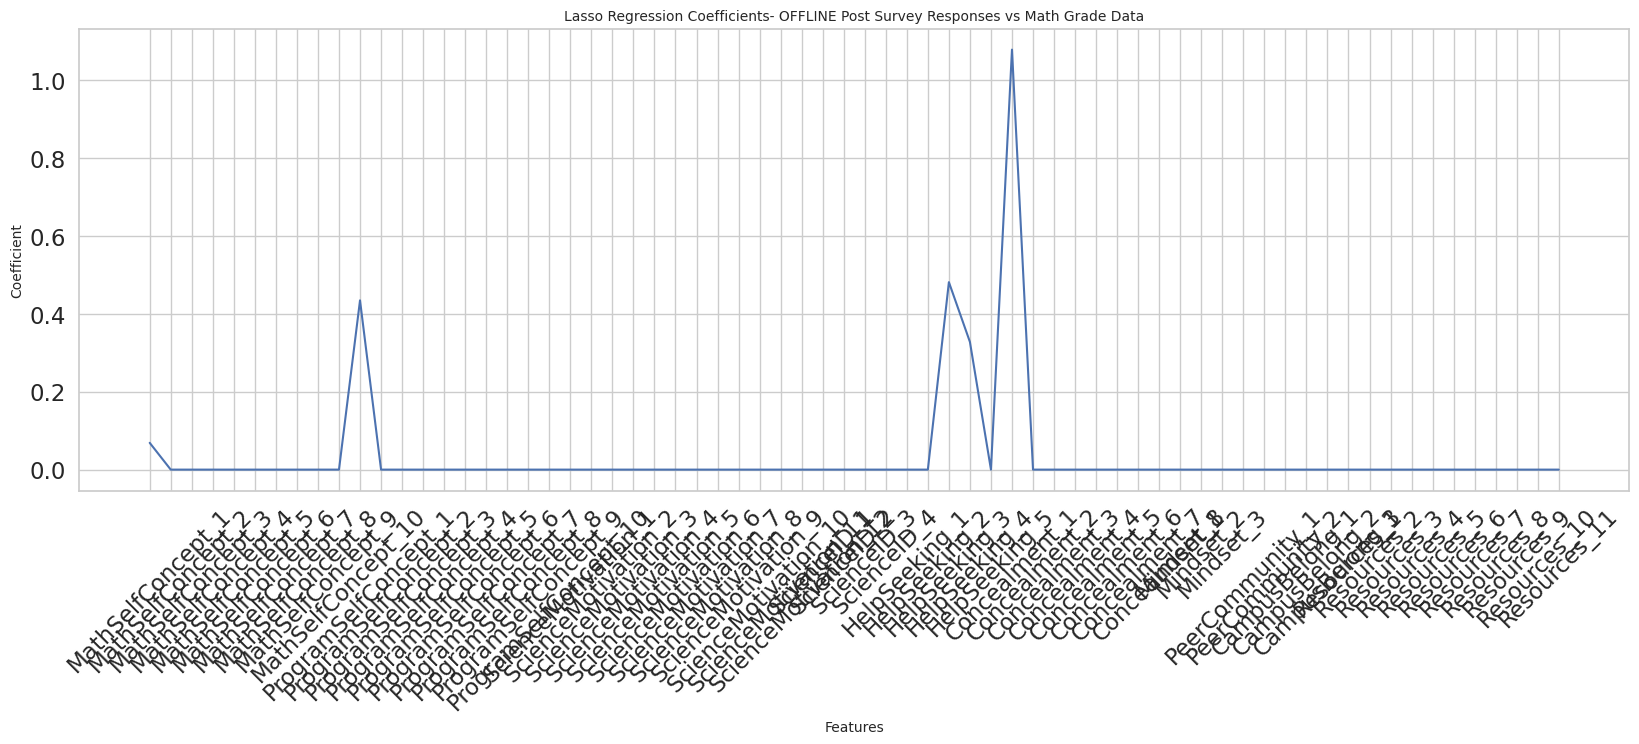

In [59]:
X_train, X_test, y_train, y_test = train_test_split(cleaned_survey_data_offline.copy().drop(["CSE20 Grade", "Math 19A Grade"], axis=1),
                                                    cleaned_survey_data_offline["Math 19A Grade"], test_size=0.2, random_state=42)
lasso = Lasso(alpha=0.04) #arbitarily picked
lasso.fit(X_train, y_train)
y_pred = lasso.predict(X_test)
# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
print("Mean Squared Error:", mse)

# Plot feature coefficients
plt.figure(figsize=(20, 6))
plt.plot(range(len(lasso.coef_)), lasso.coef_)
plt.xticks(range(len(cleaned_survey_data_offline.copy().drop(["CSE20 Grade", "Math 19A Grade"], axis=1).columns)), cleaned_survey_data_offline.copy().drop(["CSE20 Grade", "Math 19A Grade"], axis=1).columns, rotation=45)
plt.title("Lasso Regression Coefficients- OFFLINE Post Survey Responses vs Math Grade Data")
plt.xlabel("Features")
plt.ylabel("Coefficient")
plt.grid(True)
plt.show()

lasso_features_significant=list(column_names(cleaned_survey_data_offline.copy().drop(["CSE20 Grade", "Math 19A Grade"], axis=1),np.where(np.abs(lasso.coef_)>0.0)[0]))
important_feature_set_offline.update(lasso_features_significant)
feature_and_correlations={}
for feature in lasso_features_significant:
  corr = cleaned_survey_data_offline[feature].corr(cleaned_survey_data_offline["Math 19A Grade"])
  feature_and_correlations[feature]=corr

math_post_features_offline = lasso_features_significant

In [60]:
feature_and_correlations

{'MathSelfConcept_1': 0.25446911329877964,
 'ProgramSelfConcept_1': 0.3103960442612177,
 'HelpSeeking_3': 0.29547579559570386,
 'HelpSeeking_4': 0.3029366427156383,
 'Concealment_1': 0.3527493144957092}

### POST SURVEY RESPONSES + PROGRAMMING GRADE DATA

Mean Squared Error: 1.28202342855501


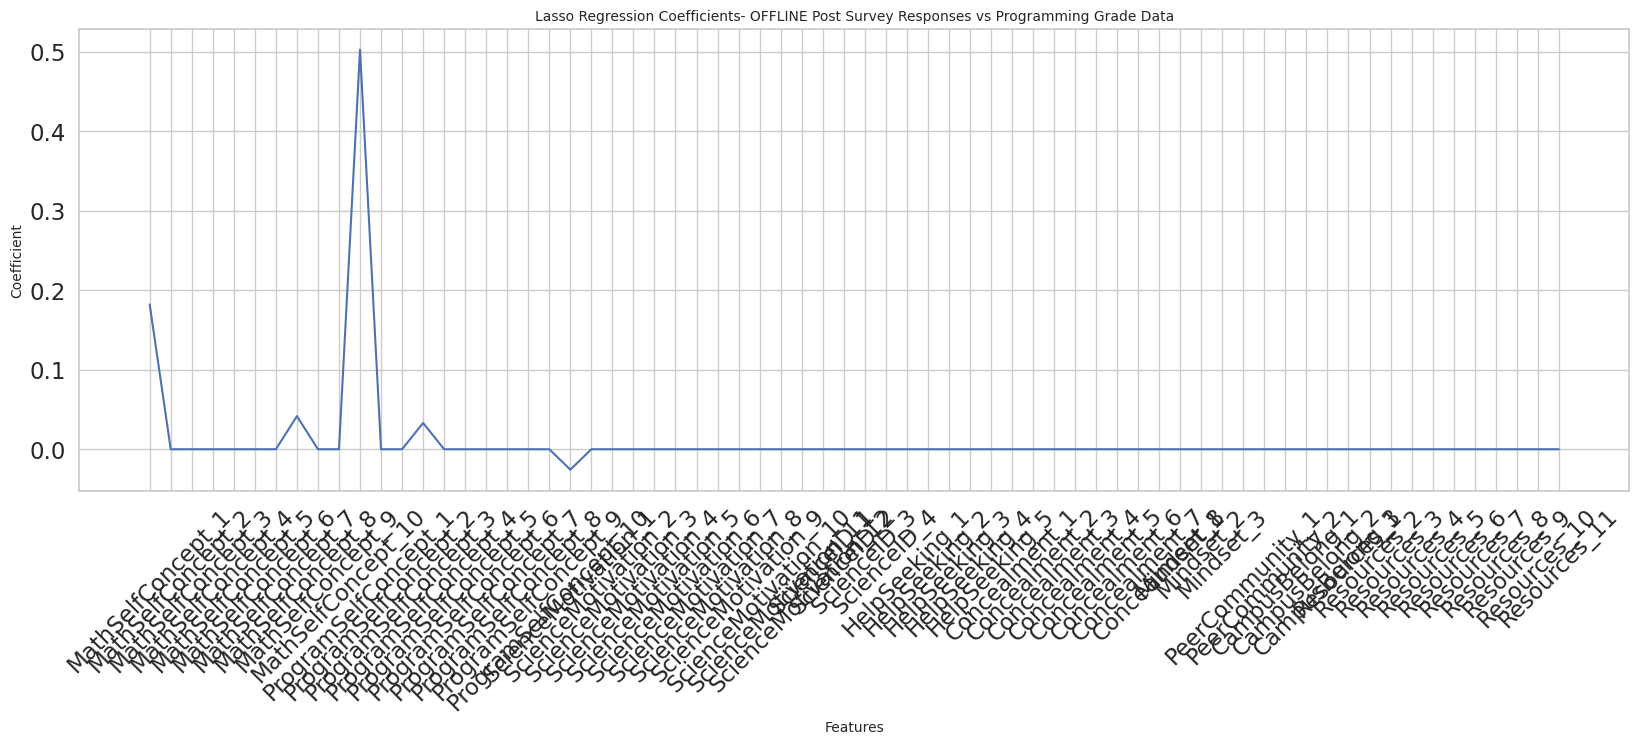

In [61]:
X_train, X_test, y_train, y_test = train_test_split(cleaned_survey_data_offline.copy().drop(["CSE20 Grade", "Math 19A Grade"], axis=1),
                                                    cleaned_survey_data_offline["CSE20 Grade"], test_size=0.2, random_state=42)
lasso = Lasso(alpha=0.046) #arbitarily picked
lasso.fit(X_train, y_train)
y_pred = lasso.predict(X_test)
# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
print("Mean Squared Error:", mse)

# Plot feature coefficients
plt.figure(figsize=(20, 6))
plt.plot(range(len(lasso.coef_)), lasso.coef_)
plt.xticks(range(len(cleaned_survey_data_offline.copy().drop(["CSE20 Grade", "Math 19A Grade"], axis=1).columns)), cleaned_survey_data_offline.copy().drop(["CSE20 Grade", "Math 19A Grade"], axis=1).columns, rotation=45)
plt.title("Lasso Regression Coefficients- OFFLINE Post Survey Responses vs Programming Grade Data")
plt.xlabel("Features")
plt.ylabel("Coefficient")
plt.grid(True)
plt.show()

lasso_features_significant=list(column_names(cleaned_survey_data_offline.copy().drop(["CSE20 Grade", "Math 19A Grade"], axis=1),np.where(np.abs(lasso.coef_)>0.0)[0]))
important_feature_set_offline.update(lasso_features_significant)
feature_and_correlations={}
for feature in lasso_features_significant:
  corr = cleaned_survey_data_offline[feature].corr(cleaned_survey_data_offline["CSE20 Grade"])
  feature_and_correlations[feature]=corr

programming_post_features_offline = lasso_features_significant

In [62]:
feature_and_correlations

{'MathSelfConcept_1': 0.20246984384931568,
 'MathSelfConcept_8': 0.19475922645214158,
 'ProgramSelfConcept_1': 0.26320924796244616,
 'ProgramSelfConcept_4': 0.2057382331200484,
 'ScienceMotivation_1': -0.18858291462932966}

### DELTA SURVEY RESPONSES + MATH GRADE DATA

Mean Squared Error: 0.838828488000661


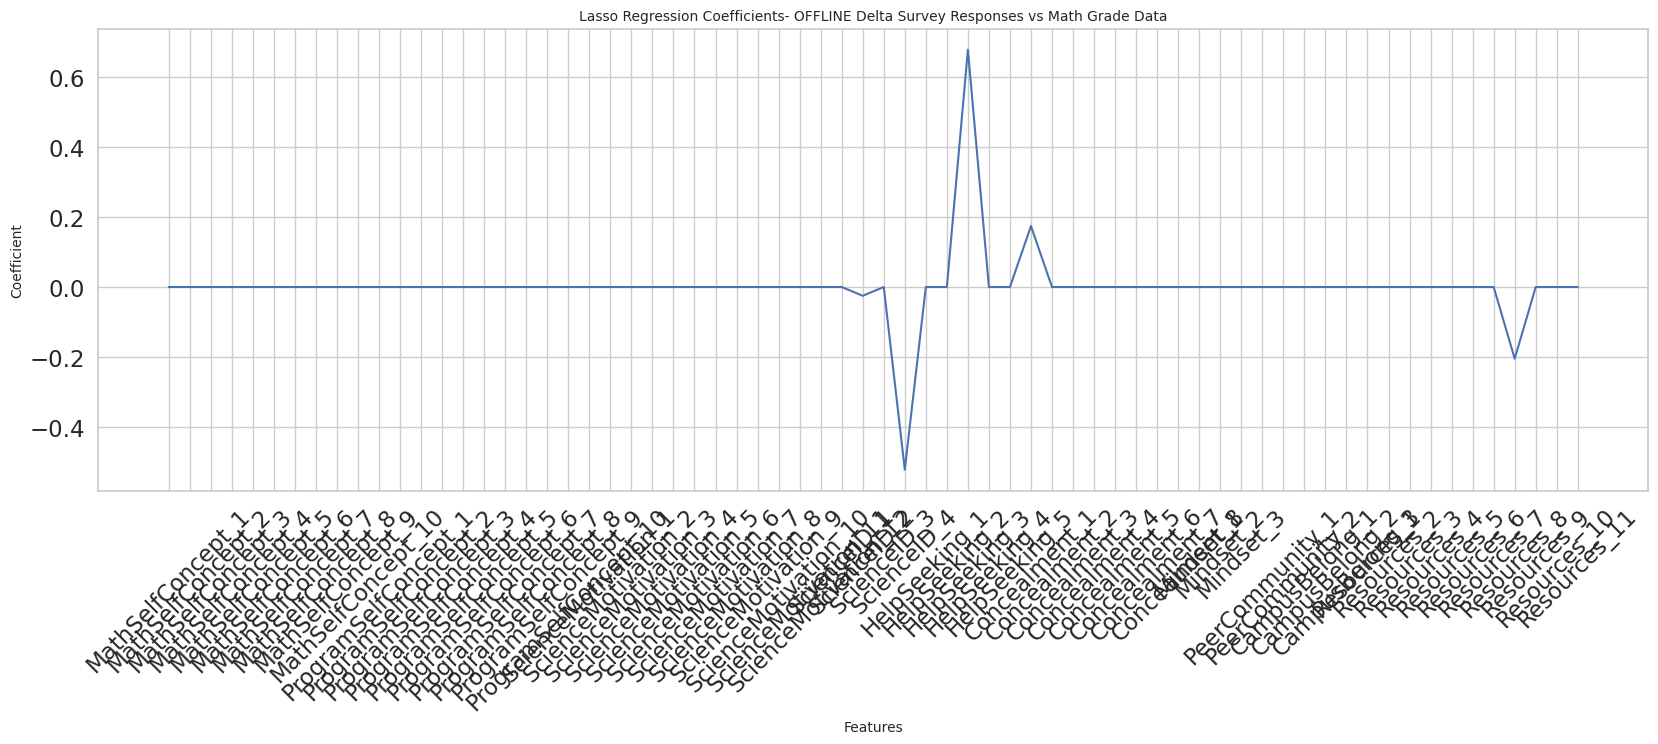

In [63]:
X_train, X_test, y_train, y_test = train_test_split(cleaned_offline_delta.copy().drop(["CSE20 Grade", "Math 19A Grade"], axis=1),
                                                    cleaned_offline_delta["Math 19A Grade"], test_size=0.2, random_state=42)
lasso = Lasso(alpha=0.05) #arbitarily picked
lasso.fit(X_train, y_train)
y_pred = lasso.predict(X_test)
# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
print("Mean Squared Error:", mse)

# Plot feature coefficients
plt.figure(figsize=(20, 6))
plt.plot(range(len(lasso.coef_)), lasso.coef_)
plt.xticks(range(len(cleaned_offline_delta.copy().drop(["CSE20 Grade", "Math 19A Grade"], axis=1).columns)), cleaned_offline_delta.copy().drop(["CSE20 Grade", "Math 19A Grade"], axis=1).columns, rotation=45)
plt.title("Lasso Regression Coefficients- OFFLINE Delta Survey Responses vs Math Grade Data")
plt.xlabel("Features")
plt.ylabel("Coefficient")
plt.grid(True)
plt.show()

lasso_features_significant=list(column_names(cleaned_offline_delta.copy().drop(["CSE20 Grade", "Math 19A Grade"], axis=1),np.where(np.abs(lasso.coef_)>0.0)[0]))
important_feature_set_offline.update(lasso_features_significant)
feature_and_correlations={}
for feature in lasso_features_significant:
  corr = cleaned_offline_delta[feature].corr(cleaned_offline_delta["Math 19A Grade"])
  feature_and_correlations[feature]=corr

math_delta_features_offline = lasso_features_significant

In [64]:
feature_and_correlations

{'ScienceID_2': -0.27834513371227926,
 'ScienceID_4': -0.31567789344985264,
 'HelpSeeking_3': 0.328663479403231,
 'Concealment_1': 0.3435741984656111,
 'Resources_8': -0.28404736703509825}

### DELTA SURVEY RESPONSES + PROGRAMMING GRADE DATA

Mean Squared Error: 0.5045387772157093


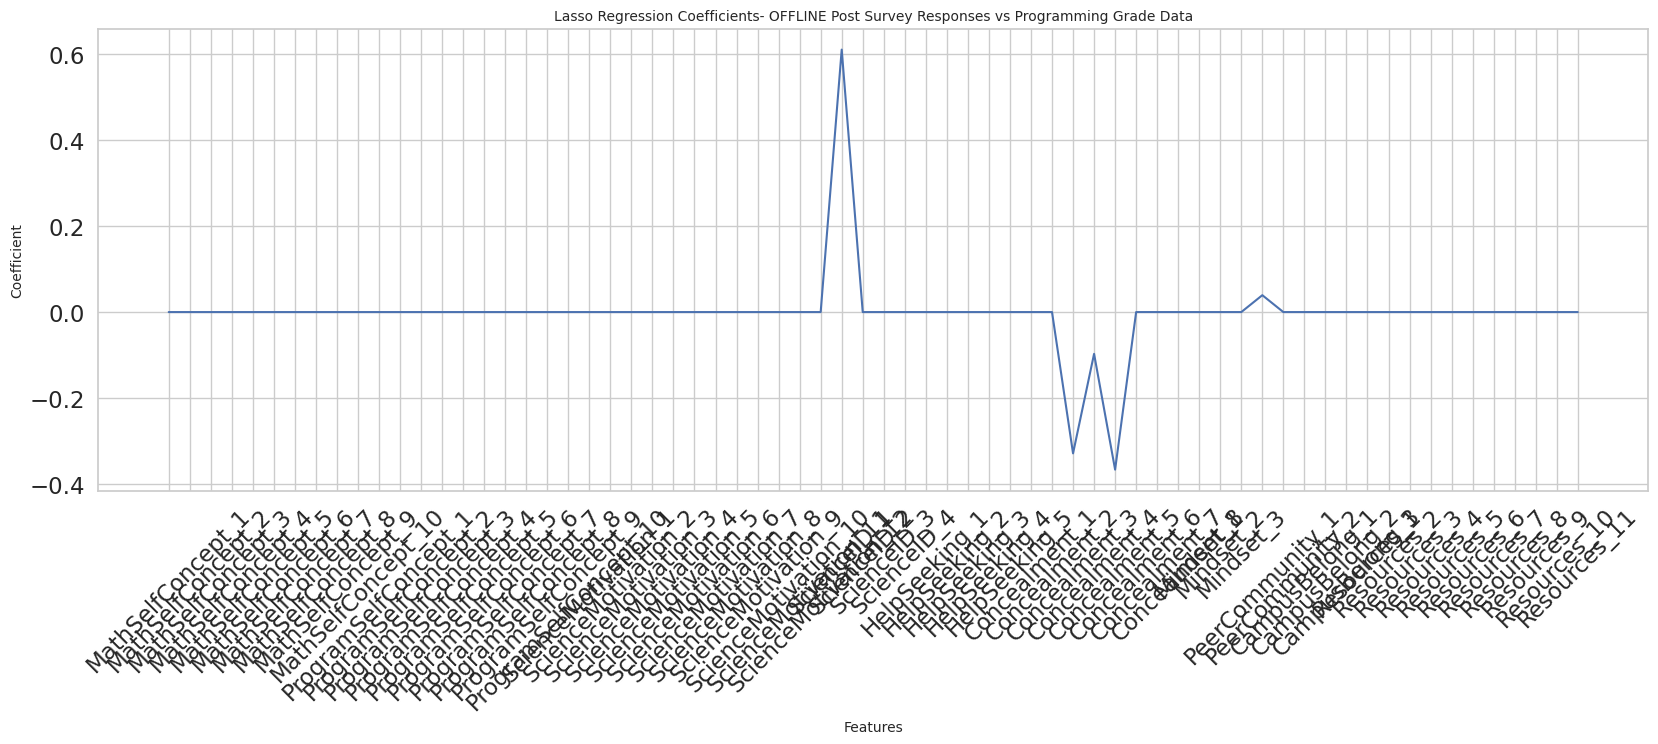

In [65]:
X_train, X_test, y_train, y_test = train_test_split(cleaned_offline_delta.copy().drop(["CSE20 Grade", "Math 19A Grade"], axis=1),
                                                    cleaned_offline_delta["CSE20 Grade"], test_size=0.2, random_state=42)
lasso = Lasso(alpha=0.047) #arbitarily picked
lasso.fit(X_train, y_train)
y_pred = lasso.predict(X_test)
# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
print("Mean Squared Error:", mse)

# Plot feature coefficients
plt.figure(figsize=(20, 6))
plt.plot(range(len(lasso.coef_)), lasso.coef_)
plt.xticks(range(len(cleaned_offline_delta.copy().drop(["CSE20 Grade", "Math 19A Grade"], axis=1).columns)), cleaned_offline_delta.copy().drop(["CSE20 Grade", "Math 19A Grade"], axis=1).columns, rotation=45)
plt.title("Lasso Regression Coefficients- OFFLINE Post Survey Responses vs Programming Grade Data")
plt.xlabel("Features")
plt.ylabel("Coefficient")
plt.grid(True)
plt.show()

lasso_features_significant=list(column_names(cleaned_offline_delta.copy().drop(["CSE20 Grade", "Math 19A Grade"], axis=1),np.where(np.abs(lasso.coef_)>0.0)[0]))
important_feature_set_offline.update(lasso_features_significant)
feature_and_correlations={}
for feature in lasso_features_significant:
  corr = cleaned_offline_delta[feature].corr(cleaned_offline_delta["CSE20 Grade"])
  feature_and_correlations[feature]=corr

programming_delta_features_offline = lasso_features_significant

In [66]:
feature_and_correlations

{'ScienceID_1': 0.31476536508966746,
 'Concealment_3': -0.26342651074879253,
 'Concealment_4': -0.27551060209191786,
 'Concealment_5': -0.3236978958889497,
 'PeerCommunity_1': 0.22110760558443596}

## Important feature set based on 2(a) and 2(b)

In [67]:
#combined important feature set
filtered_survey_data_online = cleaned_survey_data_online[list(important_feature_set_online)]
filtered_survey_data_offline = cleaned_survey_data_offline[list(important_feature_set_offline)]
len(important_feature_set_online), len(important_feature_set_offline)

(14, 16)

In [68]:
important_feature_set_online

{'Concealment_3',
 'Concealment_7',
 'Concealment_8',
 'MathSelfConcept_6',
 'MathSelfConcept_8',
 'Mindset_2',
 'ProgramSelfConcept_4',
 'Resources_11',
 'Resources_2',
 'Resources_7',
 'ScienceID_1',
 'ScienceMotivation_1',
 'ScienceMotivation_7',
 'ScienceMotivation_9'}

In [69]:
important_feature_set_offline

{'Concealment_1',
 'Concealment_3',
 'Concealment_4',
 'Concealment_5',
 'HelpSeeking_3',
 'HelpSeeking_4',
 'MathSelfConcept_1',
 'MathSelfConcept_8',
 'PeerCommunity_1',
 'ProgramSelfConcept_1',
 'ProgramSelfConcept_4',
 'Resources_8',
 'ScienceID_1',
 'ScienceID_2',
 'ScienceID_4',
 'ScienceMotivation_1'}